In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
# need to replace this with your own directory
os.chdir(r'/content/drive/My Drive/Colab Notebooks/1512')

# Part 2: Histopathological Tissue Classification

# Task 3: Biomedical image classification and interpretation [5 Marks]

# Task 3-1: Load the CNN trained on models/HMT.h5 (VGG-7 architecture), and the test set hmt_dataset/HMT_test. Evaluate the performance of the trained model on the test data, using the same metrics that are mentioned in Task1 except part 3.a. [2.5 Marks]

# Requirements

In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

# Dataset loader

In [8]:
train_dir = '/content/drive/My Drive/Colab Notebooks/1512/HMT_train' #you should change to your directory
test_dir = '/content/drive/My Drive/Colab Notebooks/1512/HMT_test' # need to replace this with your own directory.

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [ ]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)               

# Training

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [ ]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

In [ ]:
model.save('HMT.h5')

# Load Model

In [9]:
model=load_model('HMT.h5')

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

In [12]:
# def my_summary_iterator(path):
#   for r in tf_record.tf_record_iterator(path):
#     yield event_pb2.Event.FromString(r)
# train_acc = []
# train_loss = []
# train_lr = []
# #print('log/train/' + os.listdir('log/train')[2])
# for e in my_summary_iterator('log/train/' + os.listdir('log/train')[-1]):
#   for v in e.summary.value:
#     if v.tag == 'epoch_accuracy':
#       train_acc.append(v.simple_value)
#     elif v.tag == 'epoch_loss':
#       train_loss.append(v.simple_value)

In [13]:
# plt.plot(np.arange(len(train_acc)), train_acc)
# plt.xlabel('Epoch')
# plt.ylabel('Training Accuracy')
# plt.title('Training progress: Accuracy')

In [14]:
# plt.plot(np.arange(len(train_loss)), train_loss)
# plt.xlabel('Epoch')
# plt.ylabel('Training Loss')
# plt.title('Training progress: Loss')

# Repeat task 1-3b: Overall classification accuracy on the test set.

In [7]:
scores = model.evaluate(test_generator)
print(f"test loss: {scores[0]}, test accuracy: {scores[1]}")

16/16 [==============================] - 182s 11s/step - loss: 0.5554 - accuracy: 0.8347
test loss: 0.555415689945221, test accuracy: 0.8346773982048035


# Repeat task 1-3c: Class-wise classification accuracy for all classes.

In [8]:
from sklearn.metrics import confusion_matrix

batch_size = 32
Y_pred = model.predict(test_generator, 496 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
my_confusion_matrix = confusion_matrix(test_generator.classes, y_pred, normalize="true")
my_confusion_matrix = my_confusion_matrix.astype('float')/my_confusion_matrix.sum(axis=1)[:, np.newaxis]
my_confusion_matrix.diagonal()
print("class-wise accuracy: (in percentage)\n")
for i in range(8):
  print(str(i) + ": " + str(my_confusion_matrix.diagonal()[i]*100))

class-wise accuracy: (in percentage)

0: 85.48387096774194
1: 75.80645161290323
2: 77.41935483870968
3: 85.48387096774194
4: 66.12903225806451
5: 82.25806451612904
6: 95.16129032258065
7: 100.0


In [9]:
label_y_test = np.zeros((496,8))
for i in range(test_generator.classes.shape[0]):
  label_y_test[i][test_generator.classes[i]] = 1

# Repeat Task 1-3d: Plot the classification ROC and AUC curves for each class

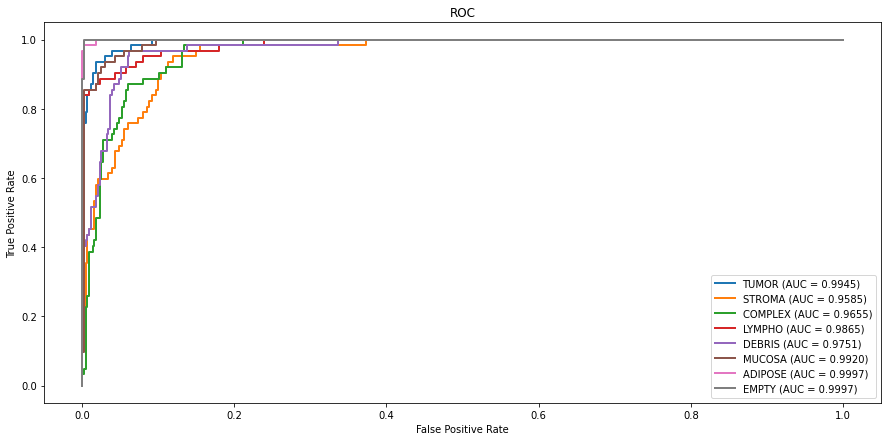

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the output
Y_pred = model.predict(test_generator, 496 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(label_y_test[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
plt.figure(figsize=(15,7))
lw = 2
label = ['TUMOR','STROMA','COMPLEX','LYMPHO','DEBRIS','MUCOSA','ADIPOSE','EMPTY']
for i in range(8):
  plt.plot(fpr[i],tpr[i],lw=lw,label= f"{label[i]} (AUC = %0.4f)" % roc_auc[i])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

# Repeat Task 1-3e: Plot the normalized confusion matrix

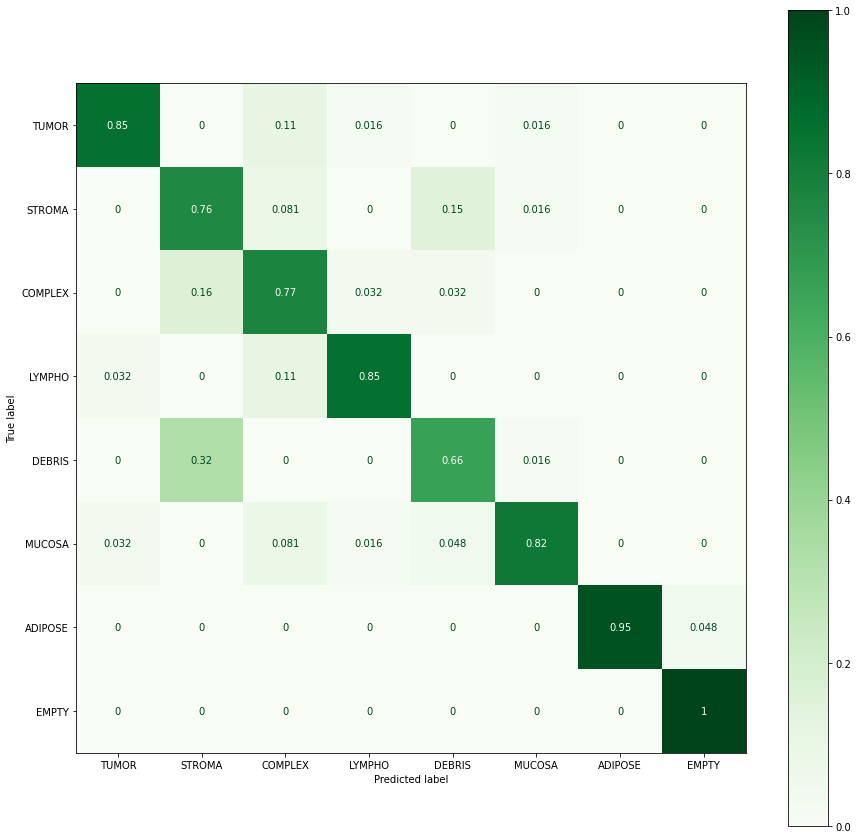

In [11]:
label = ['TUMOR','STROMA','COMPLEX','LYMPHO','DEBRIS','MUCOSA','ADIPOSE','EMPTY']
my_confusion_matrix = my_confusion_matrix/my_confusion_matrix.astype(float).sum(axis=1) # normalize
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_confusion_matrix, display_labels=label)
fig, ax = plt.subplots(figsize=(15,15)) # adjusting the output plot size
disp.plot(cmap=plt.cm.Greens,ax=ax) # plot
plt.show()

# Repeat Task 1-3f: Precision, Recall, and F-1 score on the test set.

In [12]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels) 
print(report)

              precision    recall  f1-score   support

    01_TUMOR       0.93      0.85      0.89        62
   02_STROMA       0.61      0.76      0.68        62
  03_COMPLEX       0.67      0.77      0.72        62
   04_LYMPHO       0.93      0.85      0.89        62
   05_DEBRIS       0.75      0.66      0.70        62
   06_MUCOSA       0.94      0.82      0.88        62
  07_ADIPOSE       1.00      0.95      0.98        62
    08_EMPTY       0.95      1.00      0.98        62

    accuracy                           0.83       496
   macro avg       0.85      0.83      0.84       496
weighted avg       0.85      0.83      0.84       496



# Repeat task 1-4: Show some examples of the success/failure cases of the model. Among which two classes misclassification happens the most? Provide your insights and support your answers with analytic reasons. 

In [13]:
y_pred

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 5, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 4, 1, 1, 1, 1, 2, 4, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 4, 4,
       1, 1, 1, 4, 4, 1, 1, 1, 1, 5, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 4, 2,
       2, 2, 4, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3,
       3, 3, 3, 0, 3, 3, 1, 1, 5, 1, 4, 4, 1, 4, 4, 1, 1, 1, 1, 4, 4, 1,
       4, 4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 1,
       4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 1, 4,

In [15]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

Comparing the true label and the predicted label, we can see that between "02_STROMA" and "05_DEBRIS", misclassification happens the most. It is obvious that a lot of the instances in "05_DRBRIS" have been classified as "02_STROMA" and vice versa. Looking at the actual image, in fact, most images in "02_STROMA" look simialr to those in "05_DEBRIS". The color, the texture (purple dots and red lines), and the general shape of some region look similar. Because these two classes share many similar features i.e. shape, color, and texture, so misclassification happens the most. Below are some examples of misclassification where the instances in "05_DEBRIS" have been classified as "02_STROMA".

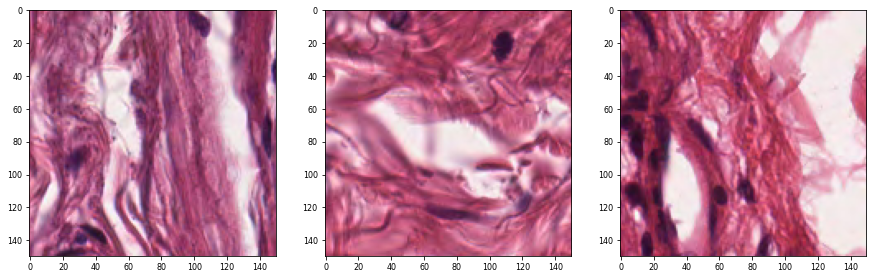

In [98]:
import tifffile as tiff
fig, ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(tiff.imread(test_dir+'/05_DEBRIS/'+'11393_CRC-Prim-HE-08_024.tif_Row_301_Col_451.tif'))
ax[1].imshow(tiff.imread(test_dir+'/05_DEBRIS/'+'11452_CRC-Prim-HE-08_021.tif_Row_1501_Col_1051.tif'))
ax[2].imshow(tiff.imread(test_dir+'/05_DEBRIS/'+'12166_CRC-Prim-HE-07_002.tif_Row_301_Col_1.tif'))
plt.show()

# Explanation

Load the explaier library

In [10]:
from xai_utils import *

Load a batch of images

In [25]:
test_generator.reset()

In [26]:
image_batch,label_batch=test_generator.next()

Classes:

In [11]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [12]:
index=8

In [20]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.8558136


Generate explanation map

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [13]:
layers=[['conv2d_3']]

In [33]:
%%time
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
explanation_map_SISE -= explanation_map_SISE.min()
explanation_map_SISE /= explanation_map_SISE.max()+10e-30

CPU times: user 217 ms, sys: 8.97 ms, total: 226 ms
Wall time: 229 ms


In [34]:
explanation_map_SISE.shape

(224, 224)

## Grad-CAM (Gradient-based Class Activation Mapping)

In [30]:
%%time
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'conv2d_3')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

CPU times: user 620 ms, sys: 20.1 ms, total: 640 ms
Wall time: 497 ms


In [31]:
explanation_map_GradCAM.shape

(224, 224)

(-0.5, 223.5, 223.5, -0.5)

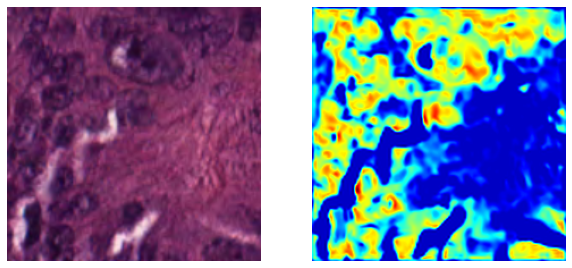

In [32]:
cam = cv2.resize(explanation_map_GradCAM, (224, 224))
cam = (cam*255).astype("uint8")
cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
img = cam + image_batch[index]
img = np.clip(img,0,255).astype("uint8")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(image_batch[index])
ax[1].imshow(img)
ax[0].axis('off')
ax[1].axis('off')

# Grad-CAM++

In [33]:
# this code is modified from the grad_cam() in the given xai_utils.py
# Basically the same code as we used in MNIST1D.ipynb, but with modified axis dimension.
import tensorflow as tf

def grad_cam_plus_plus(input_model, image, layer_name):
  # same as grad_cam
  cls = np.argmax(input_model.predict(image)) # class label
  y_c = input_model.output
  conv_output = input_model.get_layer(layer_name).output
  feedforward1 = keras.models.Model([input_model.input], [conv_output, y_c])

  # calculate the derivatives
  with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
              all_fmap_masks, predictions = feedforward1([image])
              loss = predictions[:, cls]
              first_grad = tape3.gradient(loss, all_fmap_masks)
            second_grad = tape2.gradient(first_grad, all_fmap_masks)
        third_grad = tape1.gradient(second_grad, all_fmap_masks)

  g_sum = np.sum(all_fmap_masks, axis=(0,1,2))
  numerator = second_grad[0]
  denominator = second_grad[0]*2 + third_grad[0]*g_sum
  denominator = np.where(denominator != 0, denominator, 1e-10)
  a = numerator/denominator
  ac = np.sum(a, axis=(0,1))
  a = a / ac
  w = np.maximum(first_grad[0], 0)
  lw = np.sum(w*a, axis=(0,1))
  cam = np.sum(lw*all_fmap_masks[0], axis=2)
  cam = np.maximum(cam, 0) # ReLU
  cam = cam / np.max(cam)

  return cam

In [34]:
explanation_map_GradCAM_plus_plus = grad_cam_plus_plus(model, np.expand_dims(image_batch[index], axis=0), 'conv2d_3')
explanation_map_GradCAM_plus_plus -= explanation_map_GradCAM_plus_plus.min()
explanation_map_GradCAM_plus_plus /= explanation_map_GradCAM_plus_plus.max()+10e-30
explanation_map_GradCAM_plus_plus = cv2.resize(explanation_map_GradCAM_plus_plus, (224, 224))

In [35]:
explanation_map_GradCAM_plus_plus.shape

(224, 224)

(-0.5, 223.5, 223.5, -0.5)

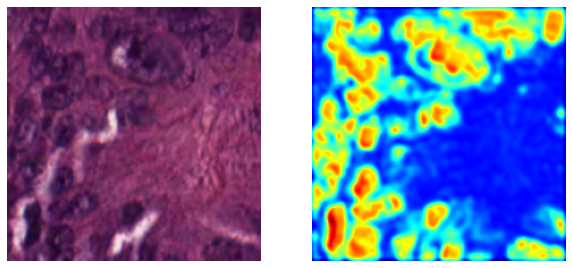

In [36]:
cam = cv2.resize(explanation_map_GradCAM_plus_plus, (224, 224))
cam = (cam*255).astype("uint8")
cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
img = cam + image_batch[index]
img = np.clip(img,0,255).astype("uint8")
grad_cam_plus_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig,ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(image_batch[index])
ax[1].imshow(grad_cam_plus_img)
ax[0].axis('off')
ax[1].axis('off')

# LIME

In [14]:
!pip install lime==0.2.0.1

     |████████████████████████████████| 275 kB 4.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=aa68eea8064a399338fe6fc5afa7d163a7dad7b47b941724e3f83ff3ab770e8a
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [15]:
from lime import lime_image

In [16]:
explainer = lime_image.LimeImageExplainer()

In [50]:
explanation = explainer.explain_instance(image_batch[index].astype('double'), model.predict, num_features=224*224, num_samples=80)

  0%|          | 0/80 [00:00<?, ?it/s]

(-0.5, 223.5, 223.5, -0.5)

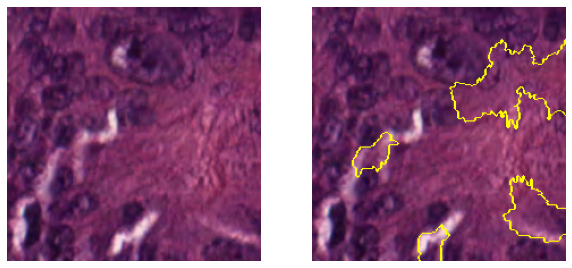

In [51]:
# custom plotting
from skimage.segmentation import mark_boundaries

seg, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True) # mask is actually the explanation that we wanted.
fig, ax = plt.subplots(1,2,figsize=(10,10))
lime_img = mark_boundaries(seg, mask)
ax[0].imshow(image_batch[index])
ax[1].imshow(lime_img)
ax[0].axis('off')
ax[1].axis('off')

In [52]:
explanation_lime = mask
explanation_lime.shape

(224, 224)

## RISE (Randomized Input Sampling for Explanation)

In [338]:
%%time
explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
explanation_map_RISE -= explanation_map_RISE.min()
explanation_map_RISE /= explanation_map_RISE.max()+10e-30

CPU times: user 4.53 s, sys: 710 ms, total: 5.24 s
Wall time: 7.26 s


## Plot the results

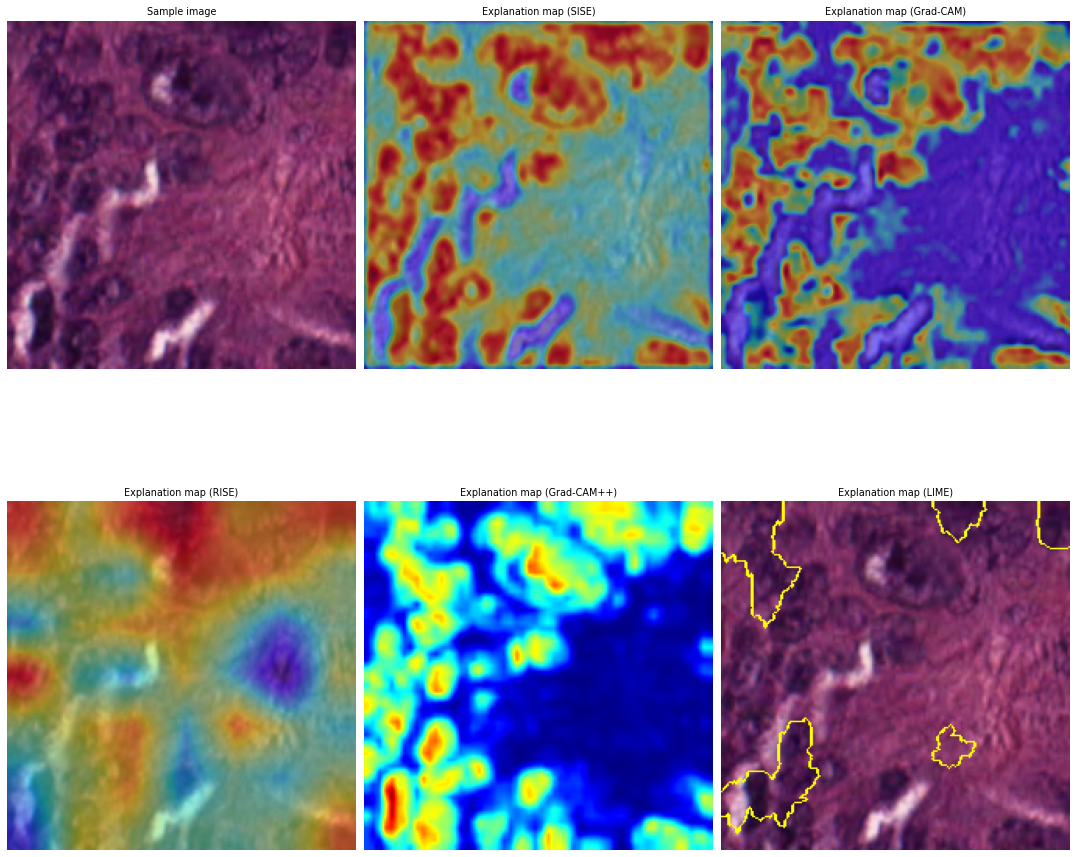

In [359]:
fig, ax = plt.subplots(2,3,figsize=(15,15))

ax[0,0].imshow(image_batch[index])
ax[0,0].axis('off')
ax[0,0].set_title('Sample image')

ax[0,1].imshow(image_batch[index])
ax[0,1].imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
ax[0,1].axis('off')
ax[0,1].set_title('Explanation map (SISE)')

ax[0,2].imshow(image_batch[index])
ax[0,2].imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
ax[0,2].axis('off')
ax[0,2].set_title('Explanation map (Grad-CAM)')

ax[1,0].imshow(image_batch[index])
ax[1,0].imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
ax[1,0].axis('off')
ax[1,0].set_title('Explanation map (RISE)')

ax[1,1].imshow(grad_cam_plus_img)
ax[1,1].axis('off')
ax[1,1].set_title('Explanation map (Grad-CAM++)')

ax[1,2].imshow(lime_img)
ax[1,2].axis('off')
ax[1,2].set_title('Explanation map (LIME)')
fig.tight_layout()


## Quantitative evaluation of the explanation algorithm

In [18]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [15]:
test_generator.reset()
drop_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)[0]
drop_rate /= (15*32)

In [16]:
test_generator.reset()
increase_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)[1]
increase_rate /= (15*32)

In [17]:
drop_rate # drop rate for SISE

86.59773295934387

In [19]:
increase_rate # increase rate for SISE

0.0

concluding from the SISE results, this does not perform well. The drop_rate is too high and the increase_rate is 0.

In [63]:
test_generator.reset()
drop_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_Grad_CAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'conv2d_3')
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_Grad_CAM, class_index=np.argmax(prediction[index]), frac=0.9)[0]
drop_rate /= (15*32)

In [64]:
test_generator.reset()
increase_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_Grad_CAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'conv2d_3')
        increase_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_Grad_CAM, class_index=np.argmax(prediction[index]), frac=0.9)[1]
increase_rate /= (15*32)

In [65]:
drop_rate # drop rate for Grad-CAM

0.379207743526894

In [66]:
increase_rate # increase rate for Grad-CAM

0.3375

Grad-CAM performs better than SISE

In [70]:
test_generator.reset()
drop_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_Grad_CAM_plus_plus = grad_cam_plus_plus(model, np.expand_dims(image_batch[index], axis=0), 'conv2d_3')
        explanation_map_Grad_CAM_plus_plus = cv2.resize(explanation_map_Grad_CAM_plus_plus, (224, 224))
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_Grad_CAM_plus_plus, class_index=np.argmax(prediction[index]), frac=0.9)[0]
drop_rate /= (15*32)

In [71]:
test_generator.reset()
increase_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_Grad_CAM_plus_plus = grad_cam_plus_plus(model, np.expand_dims(image_batch[index], axis=0), 'conv2d_3')
        explanation_map_Grad_CAM_plus_plus = cv2.resize(explanation_map_Grad_CAM_plus_plus, (224, 224))
        increase_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_Grad_CAM_plus_plus, class_index=np.argmax(prediction[index]), frac=0.9)[1]
increase_rate /= (15*32)

In [72]:
drop_rate # drop rate for Grad-CAM++

0.6242722347264323

In [73]:
increase_rate # increase rate for Grad-CAM++

0.24583333333333332

In [ ]:
# This LIME one takes hours to complete for saome reason.
test_generator.reset()

drop_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        explanation_lime = explainer.explain_instance(image_batch[index].astype('double'), model.predict, num_features=224*224, num_samples=80)
        seg, mask = explanation_lime.get_image_and_mask(explanation_lime.top_labels[0], positive_only=True)
        drop_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, mask, class_index=np.argmax(prediction[index]), frac=0.9)[0]
drop_rate /= (15*32)

In [ ]:
test_generator.reset()

increase_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        explanation_lime = explainer.explain_instance(image_batch[index].astype('double'), model.predict, num_features=224*224, num_samples=80)
        seg, mask = explanation_lime.get_image_and_mask(explanation_lime.top_labels[0], positive_only=True)
        increase_rate += calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, mask, class_index=np.argmax(prediction[index]), frac=0.9)[1]
increase_rate /= (15*32)

In [24]:
drop_rate # drop rate for LIME

0.32087401929363346

In [26]:
increase_rate # increase rate for LIME

0.010416666666666666

Concluding from the results, LIME does not give the best drop and increase rate.